# SPECFEM Users Workshop -- Day 3 (Oct. 7, 2022)

# TO DO (ctrl+f `!!!`):
- Add Day 3 slides (this cell)
- Check model update equation (Section 3)
- Explain difference between sensitivity kernel, misfit kernel, event kernel, gradient (section 3)



## Part 3: Seismic Imaging

- In this notebook we will bring all of the previous material together run a full seismic inversion to update a starting model. 
- We will generate a misfit kernel as shown in Day 2
- We use the misfit kernel to update a starting homogeneous halfspace model
- This new model is used to generate forward simulations, as shown in Day 1
- Waveforms from the initial model and updated model are compared to the True model
- Waveform misfit, introduced in Day 2, is used to determine if the model update improved waveform fit
- **Objective**: Illustrate model updates in the context of imaging. Relate manual tasks with nonlinear optimization algorithms and line searches
- These instructions should be run from inside the Docker container, using Jupyter Lab (see *Docker Preamble* in Day 0). 

-----------

**Relevant Links:** 
- Day 3 Slides !!! ADD THIS !!!
- Today's Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_3a_imaging.ipynb
- Completed Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_3a_imaging.ipynb
- Day 0 Notebook (Container Testing): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_0_container_testing.ipynb
- Day 1A Notebook (Intro SPECFEM): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1a_intro_specfem2d.ipynb
- Day 1B Notebook (Fwd. Simulations): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1b_forward_simulations.ipynb
- Day 2A Notebook (Adj. Simulations): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_2a_kernels.ipynb

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.


## 1) Background

!!! TO DO !!!
Potential topics:
- Nonlinear optimization algorithms
- Line searches
- Model perturbations

## 2) Setting Up a SPECFEM2D Working Directory

- We want to set up a clean working directory to run SPECFEM2D inside. This will help us preserve our cloned repository and reduce file clutter.
- We will use SeisFlows to automate an inversion workflow **up to** kernel generation, to save time.
- SeisFlows will run a forward simulation, calculate misfit, and run an adjoint simulation.
- Experimental setup is: one source, one receiver, starting model is a homogeneous halfspace, target model is a perturbation checkerboard.
- **Objective**: Generate a misfit kernel which we can use to update our model manually. 
- **NOTE:** We will be doing all our work in the directory /home/scoped/work/day_3. All the following cells assume that we are in this directory, so you must evaluate the '%cd' command to ensure that cells work as expected.

In [36]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from IPython.display import Image
from scipy.integrate import simps
from seisflows.tools.specfem import Model

In [10]:
# make sure we're in an empty working directory
! mkdir -p /home/scoped/work/day_3/sfexample_2
%cd /home/scoped/work/day_3/sfexample_2

# Run the example and stop after adjoint simulation
! seisflows examples setup 2 -r /home/scoped/specfem2d --event_id 1 --nsta 1 --niter 1 --with_mpi
! seisflows par stop_after evaluate_gradient_from_kernels
! seisflows submit

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/home/scoped/work/day_3/sfexample_2

                                    @@@@@@@@@@                        
                               .@@@@.    .%&(  %@.          
                            @@@@   @@@@   &@@@@@@ ,%@       
                         @@@@   @@@,  /@@              @    
                        @@@   @@@@   @@@              @     
                      @@@@   @@@@   @@@                @  @ 
                      @@@   @@@@   ,@@@                @ @  
                     @@@@   @@@@    @@@@              @@ @ @
                     @@@@   @@@@@    @@@@@          @@@ @@ @
                     @@@@    @@@@@     @@@@@@@@@@@@@@  @@  @
                      @@@@    @@@@@@        @@@&     @@@  @ 
                      @@@@@     @@@@@@@@         %@@@@#  @@ 
                        @@@@#      @@@@@@@@@@@@@@@@@   @@   
                         &@@@@@          @@@

-----------

You will know that this workflow has completed successfully after the final log message   

```bash
2022-09-16 19:57:07 (I) | stop workflow at `stop_after`: evaluate_gradient_from_kernels
```

## 3) Manually Updating a Velocity Model

- We will use this gradient that was generated using SeisFlows to update our initial model. 
- With only have one source receiver pair, we can immediately check if the misfit of the waveforms has decreased by solving for $\chi$.
- In SeisFlows, we treat models and gradients as linear arrays, so model update can be memory-intensive, but is not CPU intensive.

!!! CHECK THIS EQUATION !!!

The Model update equation can be simple as: $m_{i+1} = m_{i} - \alpha \times g$ 
Where $m_{i}$ is the current model, $m_{i+1}$ is the updated model, $g$ is the gradient and $\alpha$ is a scale factor.

### Initial Model ($m_i$)

- The initial model is our homogeneous halfspace model
- The homogeneous halfspace model defines a region with P-wave velocity 5.8km/s and S-wave velocity 3.5km/s. 
- This is the same model that we looked at in Day 1B and 2A


INITIAL MODEL
vp: [[5800. 5800. 5800. ... 5800. 5800. 5800.]]
vs: [[3500. 3500. 3500. ... 3500. 3500. 3500.]]



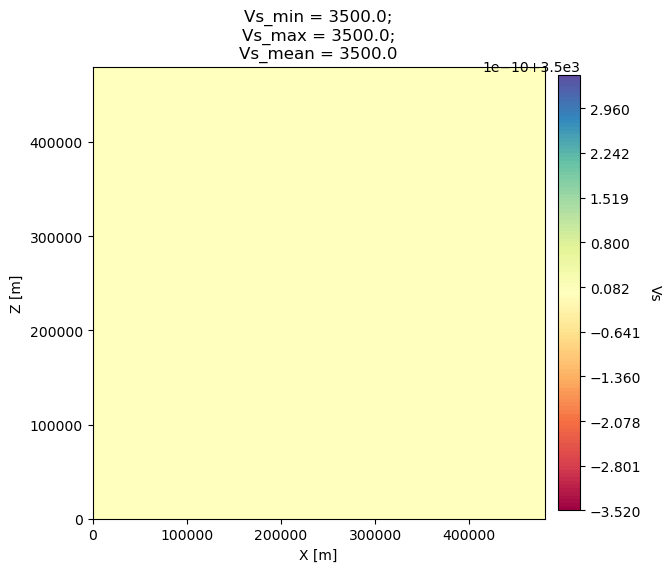

In [11]:
# Load in the initial model binary files, plot
m_init = Model("output/MODEL_INIT")
print(f"INITIAL MODEL\n{m_init.model}")
m_init.plot2d("vs")

### Misfit Kernel / Gradient ($g$)

!!! TO DO explain difference between sensitivity kernel, misfit kernel, event kernel, gradient !!!

- The gradient was generated by the interaction of our forward and adjoint wavefields.
- It represents the gradient of the misfit function and provides a search direction for model update.
- This gradient was generated using only one source-receiver pair
- This gradient was smoothed with a 2D Gaussian of vertical and horizontal half-widths of 5km
- This gradient is very similar to what we recovered after smoothing our misfit kernel in Day 2
- **NOTE**: Because the Gradient output directory does not contain coordinate information, we need to grab it from the model.


GRADIENT
vs_kernel: [[-1.0636849e-08 -1.6986203e-08 -3.1655802e-08 ...  9.9895852e-09
   2.6388767e-08  3.1614960e-08]]
vp_kernel: [[0. 0. 0. ... 0. 0. 0.]]



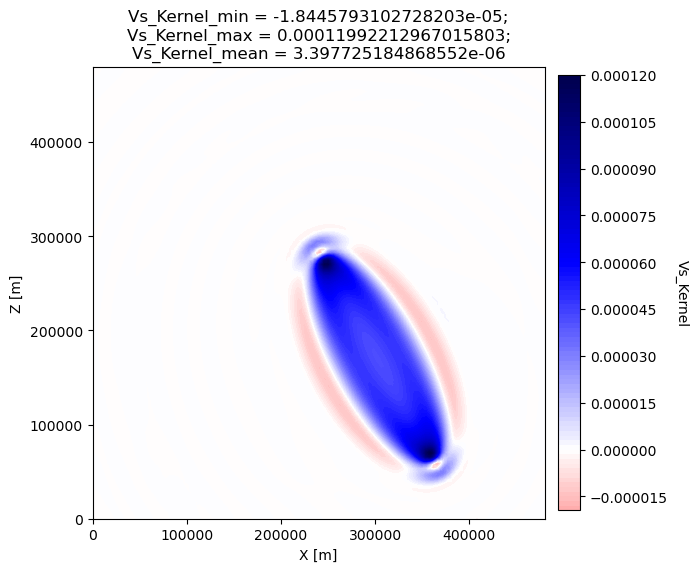

In [12]:
# Load in Gradient binary files
gradient = Model("output/GRADIENT_01")

# Assign coordinate information which is used for plotting
gradient.coordinates = {}
gradient.coordinates["x"] = m_init.coordinates["x"]
gradient.coordinates["z"] = m_init.coordinates["z"]

print(f"GRADIENT\n{gradient.model}")
gradient.plot2d("vs_kernel")

### Updated Model ($m_{i+1}$)

- The updated model can be found by scaling the gradient and adding the negative gradient to the initial model. 
- Remember that the gradient represents maximum change, and since we are solving a minimization problem, we want to use the inverse gradient.
- The updated model is represented by equation: $m_{i+1} = m_{i} - \alpha \times g$ 
- Here we do **not** scale the gradient, so $\alpha$==1

vp: [[5800. 5800. 5800. ... 5800. 5800. 5800.]]
vs: [[3500.00000001 3500.00000002 3500.00000003 ... 3499.99999999
  3499.99999997 3499.99999997]]



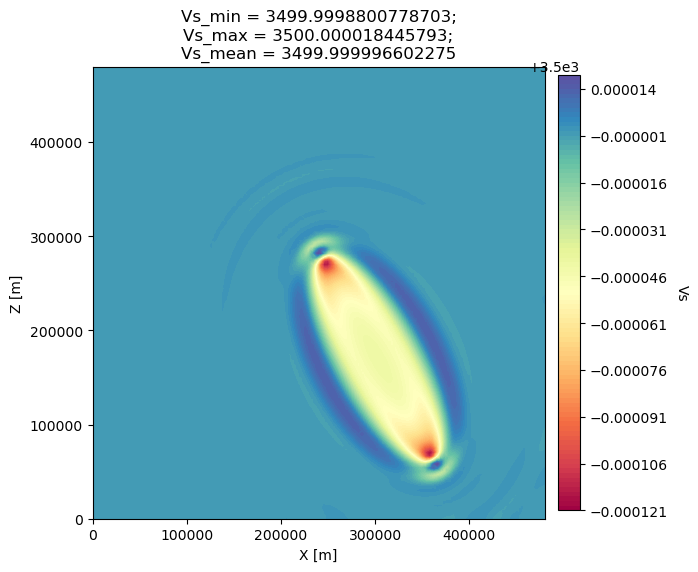

In [13]:
# We can use the SeisFlows Model class to update the model directly
m_update = m_init.copy()

# No scaling is applied here
m_update.update(vector=m_init.vector - gradient.vector)

print(m_update.model)

m_update.plot2d("vs")

#### Understanding the updated model
- Don't let the color scale fool you. Look at the values in the title to see how little the gradient changed the model
- We can see that because the gradient is **not** well scaled, the model updates only make slight changes to the Vs model ($\pm.0001$m/s give or take). 
- In order to make appreciable changes to the starting model, we need the **scale** the gradient. 
- There are many algorithms which provide scaling estimates for the gradient. 
- One thing we can try, is scaling by GTG$^{-1}$ (i.e,. the inverse of the dot product of the gradient itself)

In [14]:
# Caclulating GTG^-1
gtg = np.dot(gradient.vector, gradient.vector)
gtg_inverse = gtg ** -1 

print(f"GTG^-1 = {gtg_inverse:.2f}")

GTG^-1 = 130472.26


vp: [[5800. 5800. 5800. ... 5800. 5800. 5800.]]
vs: [[3500.00138781 3500.00221623 3500.0041302  ... 3499.99869664
  3499.996557   3499.99587512]]



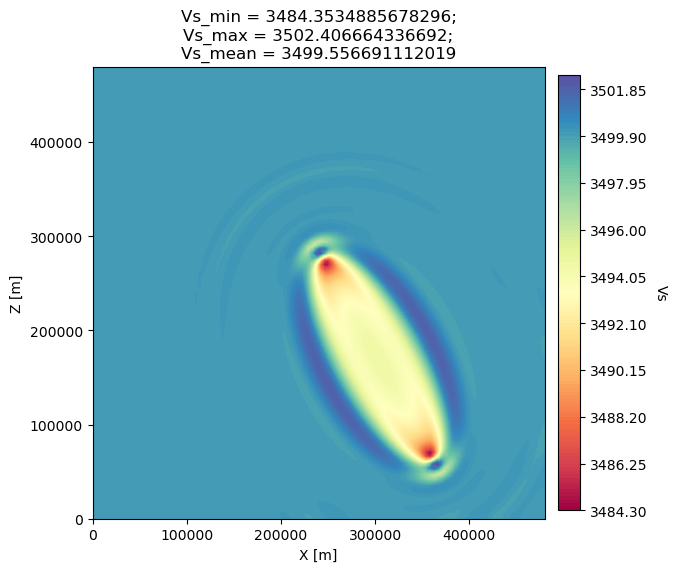

In [15]:
# Update the starting model with the scaled gradient
m_update = m_init.copy()
m_update.update(vector=m_init.vector - (gtg_inverse * gradient.vector))

print(m_update.model)

m_update.plot2d("vs")

#### Understanding the newly scaled model update
- The actual volumetric region added to the initial model is the same. We have only changed the amplitude
- The gradient is now more well scaled, and has updated our velocity model at most 25m/s. 
- We can try to use this updated velocity model to generate **new** synthetics
- We expect that the waveforms generated from this updated model will differ from our initial model synthetics
- We can compare waveform misfit for the new model synthetics against the true model to determine it's misfit value
- If misfit has reduced from the original model, then we're getting somewhere!

## 4) Forward Simulations w/ Updated Model

- We now have an updated model stored in the Python parameter `m_update`. 
- We'll use this updated model to generate a new set of synthetics
- As in Day 2, misfit will be calculated using a waveform misfit. 
- **Objective**: Determine if we have reduced waveform misfit through model update

### a) Setup SPECFEM2D working directory
- Let's start out by setting up a new SPECFEM2D working directory where we can manually run the SPECFEM binaries
- This task is very similar to Day 2 so we skip over detailed explanations

In [16]:
# Setup block for our SPECFEM2D working directory
! mkdir /home/scoped/work/day_3/specfem2d_workdir
%cd /home/scoped/work/day_3/specfem2d_workdir

# Symlink the binary files located in bin/
! ln -s /home/scoped/specfem2d/bin .
# Copy over the DATA/ directory with Par_file, SOURCE and STATIONS
! cp -r /home/scoped/specfem2d/EXAMPLES/Tape2007/DATA .
# Pick a pre-defined Par_file 
! cp DATA/Par_file_Tape2007_onerec DATA/Par_file
# Ensure we are using SOURCE #1
! cp DATA/SOURCE_001 DATA/SOURCE
# Ensure we are using only STATION #1
! head -1 DATA/STATIONS_checker > DATA/STATIONS
# Create the output directory
! mkdir OUTPUT_FILES

! ls

/home/scoped/work/day_3/specfem2d_workdir
bin  DATA  OUTPUT_FILES


### Run SPECFEM2D to get model $m_i$ synthetics

- First we'll run SPECFEM2D to get model $m_i$ synthetics
- We'll later compare these to the updated model ($m_{i+1}$) synthetics
- We'll need to adjust some parameter file parameters before running

In [17]:
# Tell SPECFEM to output binary model files
! seisflows sempar -P DATA/Par_file save_model binary
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1
! seisflows sempar -P DATA/Par_file use_existing_stations .true.

# Run SPECFEM with the homogeneous halfspace model, 1 source, 1 station
! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_mesher.txt
! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

SAVE_MODEL: default -> binary
setup_with_binary_database: 0 -> 1
use_existing_STATIONS: .false. -> .true.


In [18]:
# A succesfully completed solver will write data files, expressed in the log
! tail -n 30 OUTPUT_FILES/output_solver.txt

 Average duration of the calculation per spectral element =    4.47576838E-07  s


 Total duration of the timeloop in seconds, measured using 
 date and time of the system :    3.73000002      s

 Saving model files to directory: ./DATA/
   SAVE_MODEL type: binary

   written to file(s): ./DATA/proc000000_rho.bin
   written to file(s): ./DATA/proc000000_vp.bin
   written to file(s): ./DATA/proc000000_vs.bin
   written to file(s): ./DATA/proc000000_x.bin
   written to file(s): ./DATA/proc000000_z.bin
   written to file(s): ./DATA/proc000000_jacobian.bin

   done


 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Tape-Liu-Tromp (GJI 2007)
 ---------------------------------------------------------

### Setting the Updated Model as the 'Current' Model

- SPECEFM2D needs to be able to find the updated model we just created. 
- Luckily we can use SeisFlows to write these files in SPECFEM-readable formats.
- SPECFEM2D expects model files to be in the DATA/ directory. (**NOTE**: SPECFEM3D expects them to be in the `LOCAL_PATH` directory)
- We can OVERWRITE the updated parameters (in this case Vs and Vp) and leave the remainder of the model alone
- **IMPORTANT**: The `Par_file` parameter 'MODEL' must be set to 'gll', which tells SPECFEM to read existing model files

In [22]:
# First we make sure that the original model files are stored somewhere safe
! mkdir MODEL_INIT
! cp -r DATA/*bin MODEL_INIT
! cp -r OUTPUT_FILES/*semd MODEL_INIT

print(f"parameters to be updated are: {m_update.parameters}")

# SeisFlows will overwrite the 'Vp' and 'Vs' binary files
m_update.write(path="DATA")

# Update the `Par_file` parameter 'MODEL' to tell SPECFEM to read model files from DATA/
! seisflows sempar -P DATA/Par_file model gll

mkdir: cannot create directory ‘MODEL_INIT’: File exists
parameters to be updated are: ['vp', 'vs']
MODEL: gll -> gll


### Run SPECFEM2D with updated model

- We can now run `xmeshfem2D` and `xspecfem2D` to retrieve synthetics for our updated model
- Since we set `MODEL`==`gll`, SPECFEM2D will know to read the **updated** model files we just wrote
- Because we are messing with *model* files, we need to rerun `xmeshfem2D`
- This run will **overwrite** files stored in `OUTPUT_FILES/`. If you want to preserve these, you can copy the directory to a new path

In [23]:
! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_mesher_update.txt
! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver_update.txt

In [24]:
# We can confirm that the updated model was used during the simulation by checking the solver log
! head -236 OUTPUT_FILES/output_solver_update.txt | tail -n 15

 Material properties:
   MODEL                 : gll
   nspec                 :         1600
   assign external model :  T

   assigning an external velocity and density model
   model selected             : gll
   setup with binary database :            1

   reading external files: DATA/proc*****_rho.bin, .._vp.bin, .._vs.bin
   rho min/max =    2600.00000       2600.00000    
   vp  min/max =    5800.00000       5800.00000    
   vs  min/max =    3484.35352       3502.40674    

   done reading external model


In [25]:
# Make sure that the final model files are stored somewhere
! mkdir MODEL_UPDATE
! cp -r DATA/*.bin MODEL_UPDATE
! cp -r OUTPUT_FILES/*semd MODEL_UPDATE
! ls MODEL_UPDATE

AA.S000000.BXY.semd	    proc000000_rho.bin	proc000000_x.bin
proc000000_jacobian.bin     proc000000_vp.bin	proc000000_z.bin
proc000000_NSPEC_ibool.bin  proc000000_vs.bin


## 5) Comparing Synthetics for Initial and Updated Models

- We now have 2 synthetic seismograms. 1 for the initial model, 1 for the updated model
- In a real inversion, we would have 2$\times$N seismograms, corresonding to N stations 
- If we plot the two waveforms together we should see that they differ
- Our aim is to check both synthetics against the True model synthetics (checkerboard model)
- **Objective**: To determine if our updated model has reduced waveform misfit

### Compare Initial and Update synthetics

- We first want to see if the model update changed the synthetic waveforms
- We'll re-use some code snippets from Day 2 to plot synthetics
- We will also plot the difference between the two waveforms in blue

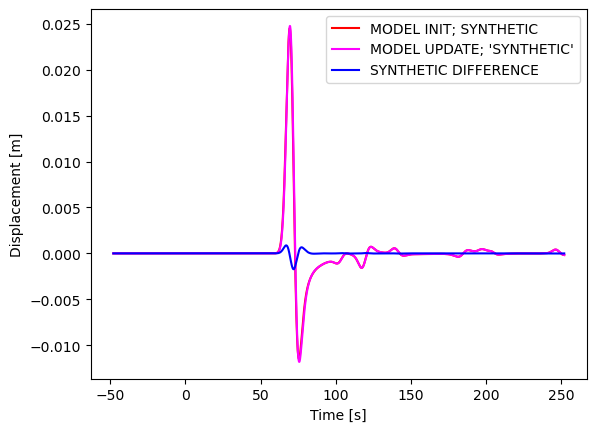

In [26]:
t_init, d_init = np.loadtxt("MODEL_INIT/AA.S000000.BXY.semd").T
t_update, d_update = np.loadtxt("MODEL_UPDATE/AA.S000000.BXY.semd").T

# Plot both waveforms using Matplotlib
plt.plot(t_init, d_init, c="r", label="MODEL INIT; SYNTHETIC")
plt.plot(t_update, d_update, c="magenta", label="MODEL UPDATE; 'SYNTHETIC'")
plt.plot(t_init, d_init - d_update, c="b", label="SYNTHETIC DIFFERENCE")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.legend()
plt.show()

#### Understanding waveform differences
- Visually the waveforms look almost the same. However we can see from the waveform difference that the two waveforms are actually different.
- Larger model updates would likely have increased the differences

### Generating True/Target model synthetics

- The final check here is to calculate waveform misfit for the initial and updated models, with respect to the Target checkerboard model.
- We will first need to generate checkerboard synthetics, which was done in Day 2
- We will also need to define our waveform misfit function
- **Objective**: Generate True model 'data' to compare against the two synthetic waveforms we have

In [27]:
# This new par file OVERWRITES the changes we made previously 
! cp -f DATA/Par_file_Tape2007_132rec_checker DATA/Par_file

! seisflows sempar -P DATA/Par_file NSTEP 5000  # 4800 -> 5000 to match the other Par_file
! seisflows sempar -P DATA/Par_file save_model binary
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1

# Ensure that SPECFEM can find the checkerboard model by naming it correctly
! cp -f DATA/model_velocity.dat_checker DATA/proc000000_model_velocity.dat_input

! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_mesher_true.txt
! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver_true.txt

NSTEP: 4800 -> 5000
SAVE_MODEL: default -> binary
setup_with_binary_database: 0 -> 1


In [28]:
# Store True model binary files and synthetics
! mkdir MODEL_TRUE
! cp -r DATA/*.bin MODEL_TRUE
! cp -r OUTPUT_FILES/*semd MODEL_TRUE
! ls MODEL_TRUE

AA.S000000.BXY.semd	    proc000000_rho.bin	proc000000_x.bin
proc000000_jacobian.bin     proc000000_vp.bin	proc000000_z.bin
proc000000_NSPEC_ibool.bin  proc000000_vs.bin


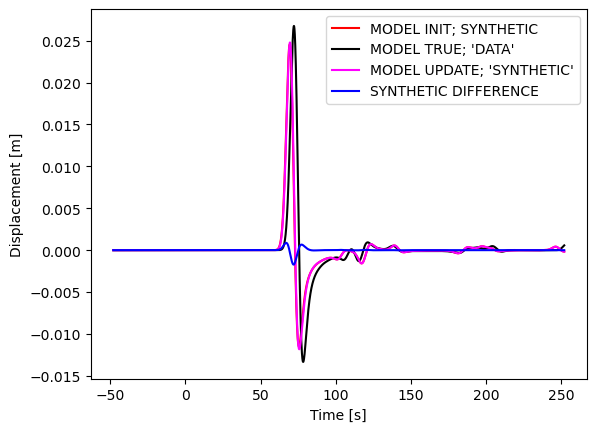

In [29]:
# Plot waveforms again but with the True model, which will be colored black
t_true, d_true = np.loadtxt("MODEL_TRUE/AA.S000000.BXY.semd").T

plt.plot(t_init, d_init, c="r", label="MODEL INIT; SYNTHETIC")
plt.plot(t_true, d_true, c="k", label="MODEL TRUE; 'DATA'")
plt.plot(t_update, d_update, c="magenta", label="MODEL UPDATE; 'SYNTHETIC'")
plt.plot(t_init, d_init - d_update, c="b", label="SYNTHETIC DIFFERENCE")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.legend()
plt.show()

### Calculating Waveform Misfit

- As in Day 2 we will calculate a waveform misfit, whose equation is: $ \chi = \frac{1}{2} \int [d(t)-s(t)]^2 dt~$
- We want to compare data with both the True model and the updated model
- **Objective**: Determine if the model update has reduced waveform misfit

In [32]:
# Integrate using scipy
dt = t_true[1] - t_true[0]  # represents the time step, or `dt`. Same for all waveforms

misfit_init = 1/2 * simps((d_true - d_init)**2, dx=dt)
misfit_update = 1/2 * simps((d_true - d_update)**2, dx=dt)

print(f"misfit_init = {misfit_init:.3E}")
print(f"misfit_true = {misfit_update:.3E}")
print(f"difference = {misfit_init - misfit_update:.3E}")

misfit_init = 1.453E-03
misfit_true = 1.332E-03
difference = 1.213E-04


---------------

**Mission accomplished!**
- We have successfully reduced the waveform misfit for a single source receiver pair by updating our velocity model.
- The misfit reduction is small because it is tied to the gradient and scale factor chosen
- We could increase the scale factor to achieve a more favorable misfit reduction, however if we go too far, we may end up increasing the misfit.
- Algorithmically, this step is encapsulated in a `line search`, which attempts to find an appropriate scale factor 
- There are many types of nonlinear optimization algorithms (e.g., gradient descent, L-BFGS) which are used to determine scale factors in an effort to minimize misfit
- **NOTE** each evaluation of a line search requires re-running the forward simulation with a trial model


## 6) A Multi-event, Multi-station Inversion

- Real seismic inversions use multiple events recorded at multiple stations to increase coverage and reduce nonuniqueness
- The principles are the same: calculate synthetics through a starting model, quantify data-synthetic misfit, generate kernels through an adjoint simulation, update model using gradient
- Here we attempt a multi-event, multi-station model update with the tools we just covered
- We will use 10 events $\times$ 10 stations = 100 waveforms
- We forgo visualizations and detailed explanations for the sake of brevity

### a) Generating 100 Target Model Synthetics

- Checkerboard model used to generate 'data'

In [45]:
# make sure we're in an empty working directory
! mkdir -p /home/scoped/work/day_3/inversion_example
%cd /home/scoped/work/day_3/inversion_example

# Setup SPECFEM2D working directory
! cp -r /home/scoped/specfem2d/EXAMPLES/Tape2007/DATA .
! cp -f DATA/Par_file_Tape2007_132rec_checker DATA/Par_file
! seisflows sempar -P DATA/Par_file save_model binary
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1
! seisflows sempar -P DATA/Par_file use_existing_stations .true.
! head -10 DATA/STATIONS_checker > DATA/STATIONS  # 10 stations
! mkdir OUTPUT_FILES

# This new par file OVERWRITES the changes we made previously 
! seisflows sempar -P DATA/Par_file NSTEP 5000  # 4800 -> 5000 to match the other Par_file
! seisflows sempar -P DATA/Par_file save_model binary
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1

# Ensure that SPECFEM can find the checkerboard model by naming it correctly
! cp -f DATA/model_velocity.dat_checker DATA/proc000000_model_velocity.dat_input

/home/scoped/work/day_3/inversion_example
SAVE_MODEL: default -> binary
setup_with_binary_database: 0 -> 1
use_existing_STATIONS: .true. -> .true.
NSTEP: 4800 -> 5000
SAVE_MODEL: binary -> binary
setup_with_binary_database: 1 -> 1


In [46]:
# Run through 10 sources and generate 'data' for 10 stations. 
for i in range(1, 11):
    source_fid = f"SOURCE_{i:0>3}"
    source_path = f"DATA/{source_fid}"
    
    if os.path.exists("DATA/SOURCE"):
        os.remove("DATA/SOURCE")
    shutil.copy(source_path, "DATA/SOURCE")
    
    # Run xmeshfem and xspecfem
    ! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_mesher_update.txt
    ! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver_update.txt
    
    # Move the synthetics so they don't get overwritten
    os.makedirs(os.path.join(source_fid, "DATA"))
    for src in glob("OUTPUT_FILES/*.semd"):
        dst = os.path.join(source_fid, "DATA", os.path.basename(src))
        os.rename(src, dst)

### b) Generating 100 Initial Model Synthetics

- Homogeneous halfspace initial model
- We need the forward wavefield (output from `SAVE_FORWARD`) from EACH forward simulation to run each subsquent adjoint simulation
- For large domains (especially in 3D) these forward wavefields are large files (on the order of GB)
- It is not preferable to save these large files for long periods of time, so it is more ideal to calculate misfit, run adjoint simulations, store kernels and remove the forward wavefield
- We will follow that practice here and generate synthetics, calculate misfit, generate adjoint sources, and run the adjoint simulation in one step

In [ ]:
# make sure we're in an empty working directory
! mkdir -p /home/scoped/work/day_3/inversion_example
%cd /home/scoped/work/day_3/inversion_example

# Setup SPECFEM2D working directory
! cp DATA/Par_file_Tape2007_onerec DATA/Par_file
! mkdir OUTPUT_FILES

# Edit Par_file to get the correct output files
! seisflows sempar -P DATA/Par_file save_model binary
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1
! seisflows sempar -P DATA/Par_file use_existing_stations .true.
! seisflows sempar -P DATA/Par_file save_forward .true.

/home/scoped/work/day_3/inversion_example
ln: failed to create symbolic link './bin': File exists
mkdir: cannot create directory ‘OUTPUT_FILES’: File exists
SAVE_MODEL: default -> binary
setup_with_binary_database: 0 -> 1
use_existing_STATIONS: .false. -> .true.
SAVE_FORWARD: .false. -> .true.


In [43]:
# Run through 10 sources and generate synthetics for 10 stations. 
for i in range(1, 11):
    source_fid = f"SOURCE_{i:0>3}"
    source_path = f"DATA/{source_fid}"
    
    if os.path.exists("DATA/SOURCE"):
        os.remove("DATA/SOURCE")
    shutil.copy(source_path, "DATA/SOURCE")
    
    # Run xmeshfem and xspecfem
    ! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_mesher_update.txt
    ! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver_update.txt
    
    # Move the synthetics so they don't get overwritten
    os.makedirs(os.path.join(source_fid, "SYN"))
    for src in glob("OUTPUT_FILES/*.semd"):
        dst = os.path.join(source_fid, "SYN", os.path.basename(src))
        os.rename(src, dst)
        
    # Calculate misfit and adjoint sources for each of the source-receiver pairs
    # !!! complete this small inversion example !!!
    # !!! calculate misfit, adjoint source, change parameters run adj sim, change parameters back !!!
    # !!! sum kernels, smooth, update model !!!

        
    

## 7) Automating Inversions using SeisFlows

- Of course, now that we have gone through the rigorous manual exercise of updating a velocity model, we can see how SeisFlows automates this procedure.
- SeisFlows contains a built-in optimization library, which features gradient-descent, non-linear conjugate gradient (NLCG), and L-BFGS nonlinear optimization alogirthms
- This library takes care of the scaling of the gradient, automating the line search and model update
- Under the hood, SeisFlows essentialy performs what we just did, scaling the velocity model, re-running forward simulations and comparing misfit values
- Misfit is either calculated with the default preprocessing module, or using Pyatoa, a software designed specifically for waveform misfit quantification.

In [ ]:
! mkdir /home/scoped/work/day_3/sfexample_2
%cd /home/scoped/work/day_3/sfexample_2
! seisflows examples setup 2 -r /home/scoped/specfem2d --event_id 1 --niter 1 --nsta 1 --with_mpi

!!! analyze log message above here !!!

In [ ]:
! seisflows submit

-------------

The task will be finished when you see the log message:

```bash
////////////////////////////////////////////////////////////////////////////////
                             COMPLETE ITERATION 01                              
////////////////////////////////////////////////////////////////////////////////
2022-09-16 21:25:38 (I) | setting current iteration to: 2
```

In [ ]:
! echo "> output/ contains models, gradients, etc."
! ls output
! echo

! echo "> MODEL directories contain SPECFEM formatted model files"
! ls output/MODEL_INIT
! echo

! echo "> GRADIENT directories contain regularized misfit kernels"
! ls output/GRADIENT_01
! echo

In [ ]:
# Models/gradients can be plotted directly from the command line
! seisflows plot2d MODEL_01 vs --savefig m_01_vs.png
Image("m_01_vs.png")

Under the hood, SeisFlows is simply running a number of individual SPECFEM working directories

In [ ]:
! ls scratch/solver/001